# GAN  (Generative Adversarial Neural Network )
Одна из пословиц гласит **"Кто сегодня обманет, тому завтра не поверят."** В этой домашней работе вы соберете две нейросети, цель одной обмануть, а второй раскрыть обман. Данная работа будет использовать сложный датасет **celebA"**. Посмотрим, что он из себя представляет. 



In [1]:
import numpy as np
import tarfile 

from PIL import Image

In [2]:
#функция загружает N изображений размером size*size 
def load_image(path, N = 10000, size = 64):
    assert N < 202599
    tar = tarfile.open(path, "r")
    X = []
    for member in tar.getmembers()[:N]:
        f = tar.extractfile(member)
        if f is not None:
            im = Image.open(f)
            w, h = im.size
            im = im.crop((0, 20, w, h -20))
            im = im.resize((size, size),Image.ANTIALIAS)
            X.append(np.array(im))
    X = np.asarray(X)
    return X

## Загрузка датасета и его визуализация

In [3]:
path = "./dataset/img_align_celeba.tar"
N = 35000
X = load_image(path, N)

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

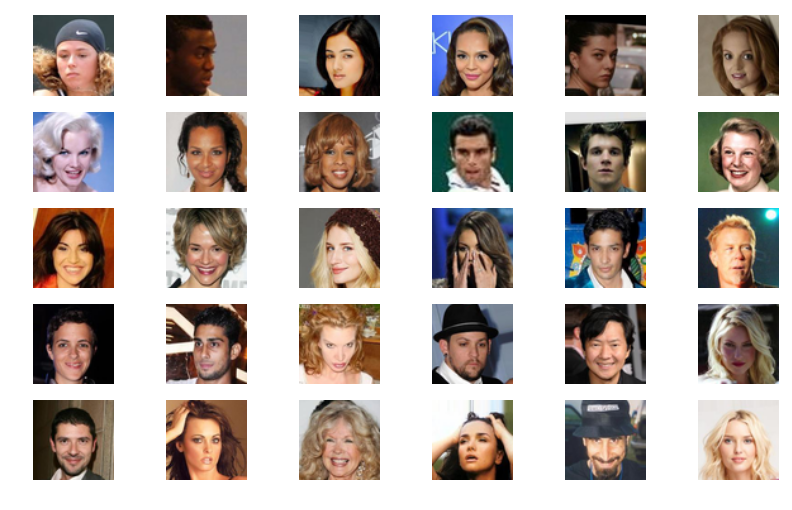

In [5]:
samples_per_column = 5
samples_per_row = 6
plt.figure(figsize=(10, 6))
for i in range(samples_per_column):
    idxs = np.random.choice(N, samples_per_row, replace=False)
    for j in range(samples_per_row):
        plt_idx = j * samples_per_column + i + 1
        plt.subplot(samples_per_column, samples_per_row, plt_idx)
        plt.imshow(X[idxs[j]].astype('uint8').reshape(64, 64, 3))
        plt.axis('off')
plt.show()

Итак это лица людей. Расставим все точки над **i**. <br>
**Цель:** Собрать GAN и научится генерировать лица людей

# Архетектура GAN
Для начала вспомним, что мы делали в самой первой домашней работе. Мы собирали автоэнкодер. Схему можно было разделить на 2 части:
<br>

1) Декодер принимает на вход картинку(большой вектор). Преодразует в маленький вектор. 
2) Енкодер  работает по обратной схеме. По маленькому вектору восстанавливается картинка. 
![](img/fcautoenc.png)

Архитектура ГАН похожа, части меняются местами. <br>
1) Генератор преобразует входной случайный вектор в изображение 
<br>
2) Дискриминатор преобразует изображение в вероятность того, что оно является несгенерированным. 
<br>
Ну и так как мы уже умеем писать сверточные сети, то итоговая модель выглядит так: 
![](img/arch.png)

В итоге у нас должна получится система умеющая вот так :)
![](img/model.png)
Весьма прикольно? Тогда вперед сделаем эту сеть!

In [6]:
import theano
import lasagne

from theano import tensor as T
from lasagne.nonlinearities import *
from lasagne.layers import *
from collections import OrderedDict

input_X = T.tensor4("X", dtype = 'float32')
input_noise = T.matrix("target Y integer",dtype='float32')


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release.  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 960M (CNMeM is enabled with initial size: 35.0% of memory, cuDNN 5105)


Соберем генератор: <br>
1) Для этого используйте: Deconv2DLayer, UpScaling2D или batch_norm
<br>
2) Тонкий момент: какую функцию активации вы будете использовать для последнего слоя? Нужно понимать, что данная функция должна быть ограничена. Почему?


In [7]:
def build_generator( z):
    l_in = lasagne.layers.InputLayer(shape=(None, 100), input_var=z)

    l_hid1 = lasagne.layers.batch_norm(lasagne.layers.DenseLayer(
        l_in, num_units=1024 * 6 * 6,
        W=lasagne.init.Normal(0.02),
        nonlinearity=lasagne.nonlinearities.leaky_rectify))

    l_reshaped = lasagne.layers.ReshapeLayer(l_hid1, shape=(-1, 1024, 6, 6))

    l_deconv1 = lasagne.layers.batch_norm(lasagne.layers.TransposedConv2DLayer(
        l_reshaped, 512, filter_size=(4, 4), stride=(2, 2), crop=2,
        W=lasagne.init.Normal(0.02),
        nonlinearity=lasagne.nonlinearities.leaky_rectify))

    print(l_deconv1.output_shape)

    l_deconv2 = lasagne.layers.batch_norm(lasagne.layers.TransposedConv2DLayer(
        l_deconv1, 256, filter_size=(4, 4), stride=(2, 2), crop=2,
        W=lasagne.init.Normal(0.02),
        nonlinearity=lasagne.nonlinearities.leaky_rectify))

    print(l_deconv2.output_shape)

    l_deconv3 = lasagne.layers.batch_norm(lasagne.layers.TransposedConv2DLayer(
        l_deconv2, 128, filter_size=(4, 4), stride=(2, 2), crop=2,
        W=lasagne.init.Normal(0.02),
        nonlinearity=lasagne.nonlinearities.leaky_rectify))

    print(l_deconv3.output_shape)

    l_deconv4 = lasagne.layers.TransposedConv2DLayer(
        l_deconv3, 3, filter_size=(4, 4), stride=(2, 2), crop=3,
        W=lasagne.init.Normal(0.02),
        nonlinearity=lasagne.nonlinearities.tanh)

    print(l_deconv4.output_shape)

    return l_deconv4

Проблем с данной частью быть не должно (если вы добросовестно отнеслись к hw4). Собирем дискриминатор.

In [8]:
def build_discriminator(input_var):
    l_in = lasagne.layers.InputLayer(shape=(None, 3, 64, 64),
                                     input_var=input_var)

    l_conv1 = lasagne.layers.Conv2DLayer(
        l_in,
        num_filters=16,
        filter_size=(4, 4),
        stride=2,
        pad=3,
        nonlinearity=lasagne.nonlinearities.leaky_rectify)

    print(l_conv1.output_shape)

    l_conv1 = lasagne.layers.batch_norm(
        l_conv1)

    l_conv2 = lasagne.layers.Conv2DLayer(
        l_conv1,
        num_filters=32,
        filter_size=(4, 4),
        stride=2,
        pad=2,
        nonlinearity=lasagne.nonlinearities.leaky_rectify)

    l_conv2 = lasagne.layers.batch_norm(
        l_conv2)

    print(l_conv2.output_shape)

    l_conv3 = lasagne.layers.Conv2DLayer(
        l_conv2,
        num_filters=64,
        filter_size=(4, 4),
        stride=2,
        pad=2,
        nonlinearity=lasagne.nonlinearities.leaky_rectify)

    l_conv3 = lasagne.layers.batch_norm(
        l_conv3)

    print(l_conv3.output_shape)

    l_conv4 = lasagne.layers.Conv2DLayer(
        l_conv3,
        num_filters=128,
        filter_size=(4, 4),
        stride=2,
        pad=2,
        nonlinearity=lasagne.nonlinearities.leaky_rectify)

    l_conv4 = lasagne.layers.batch_norm(
        l_conv4)

    print(l_conv4.output_shape)

    l_out = lasagne.layers.DenseLayer(
        l_conv4, num_units=1,
        nonlinearity=sigmoid)

    return l_out

In [9]:
dis_net = build_discriminator(input_X)
gen_net = build_generator(input_noise)

(None, 16, 34, 34)
(None, 32, 18, 18)
(None, 64, 10, 10)
(None, 128, 6, 6)
(None, 512, 10, 10)
(None, 256, 18, 18)
(None, 128, 34, 34)
(None, 3, 64, 64)


Какже такую сеть тренировать? <br>
Что мы имеем? <br>
Генератор только генерирует изображения.
<br>
Дискриминатор же может принимать на вход 2 разных объекта:<br>
1) Реальную картинку.
<br>
2) Результат работы генератора. 

In [10]:
gen_img = get_output(gen_net)
prob_real = get_output(dis_net)
prob_fake = get_output(dis_net, gen_img)

Параметры обоих сетей.

In [11]:
params_gen = lasagne.layers.get_all_params(gen_net, trainable=True)
params_dis = lasagne.layers.get_all_params(dis_net, trainable=True)

Считаем функциюю потерь. <br>
Генератор будем штрафовать тогда, когда дискриминатор угадывает реальную картинку. 
<br>
Дискриминатор штрафуем и за ошибки на реальных картинках, и на ошибках на сгенерированных картинках. 
<br>
Можно пользоваться бинарной кроссэнтропией (lasagne.objectives.binary_crossentropy)

In [12]:
loss_gen = lasagne.objectives.binary_crossentropy(prob_fake, 1).mean()
loss_dis = ( lasagne.objectives.binary_crossentropy(prob_real, 1)
+ lasagne.objectives.binary_crossentropy(prob_fake, 0) ).mean()

In [14]:

updates_gen = lasagne.updates.adam(loss_gen, params_gen,learning_rate= 0.0002, beta1= 0.5)
updates_dis = lasagne.updates.adam(loss_dis, params_dis, learning_rate= 0.0002, beta1= 0.5)
updates = OrderedDict(updates_gen.items() + updates_dis.items())

Компилируем все

In [15]:
train = theano.function([input_X, input_noise], [loss_dis, loss_gen], updates=updates)
loss = theano.function([input_X, input_noise], [loss_dis, loss_gen])
gen = theano.function([input_noise], get_output(gen_net))

In [16]:
def iterate_minibatches(inputs, batchsize, shuffle=False):
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        noise = lasagne.utils.floatX(np.random.rand(batch_size, 100))
        yield inputs[excerpt], noise

Вернемся к выходному слою генератора. В зависимости от функции активации он генерирует какие-то значения в общем случае не совпадающие с параметрами RGB, поэтому нам нужно 2 функции: <br>
1) Первая линейно отображает RGB в область значений выбранной функции активации.
<br>
2) Вторая функция ей обратная. 

In [21]:
def transform(X):
    return lasagne.utils.floatX((X).transpose(0, 3, 1, 2)/127.5 - 1.)

def inverse_transform(X):
    X = (X.transpose(0, 2, 3, 1)+1.)/2.
    return X

In [23]:
def show_samples(gen, m = 3, n = 3):    
    Z = lasagne.utils.floatX(np.random.rand(batch_size, 100))
    samples = gen(Z)
    samples = inverse_transform(samples)
    samples_per_column = m
    samples_per_row = n
    plt.figure(figsize=(10, 6))
    for i in range(samples_per_column):
        idxs = np.random.choice(len(samples), samples_per_row, replace=False)
        for j in range(samples_per_row):
            plt_idx = j * samples_per_column + i + 1
            plt.subplot(samples_per_column, samples_per_row, plt_idx)
            plt.imshow((samples[idxs[j]]))
            plt.axis('off')
    plt.show()

Ну и все учим и наслаждаемся прекрасными лицами:)

In [ ]:
import time

num_epochs = 5
batch_size = 64 

for epoch in range(num_epochs):
    train_batches = 0
    dis_loss = 0
    gen_loss = 0
    start_time = time.time()
    for batch in iterate_minibatches(transform(X), batch_size):  
        inputs, noise = batch
        d_loss, g_loss = train( inputs, noise)
        train_batches += 1
        dis_loss += d_loss 
        gen_loss += g_loss
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  gen loss (in-iteration):\t\t{:.6f}".format(gen_loss / train_batches))
    print("  dis loss (in-iteration):\t\t{:.6f} ".format(
        dis_loss / train_batches ))
    show_samples(gen)

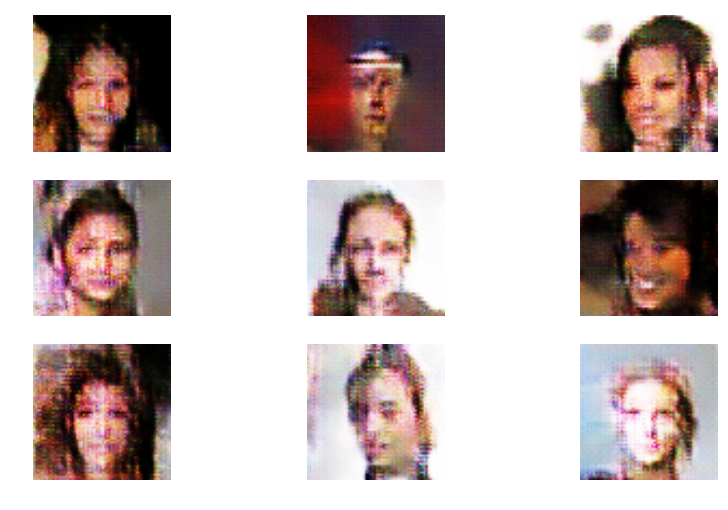